100%|██████████| 50/50 [00:02<00:00, 17.22it/s]


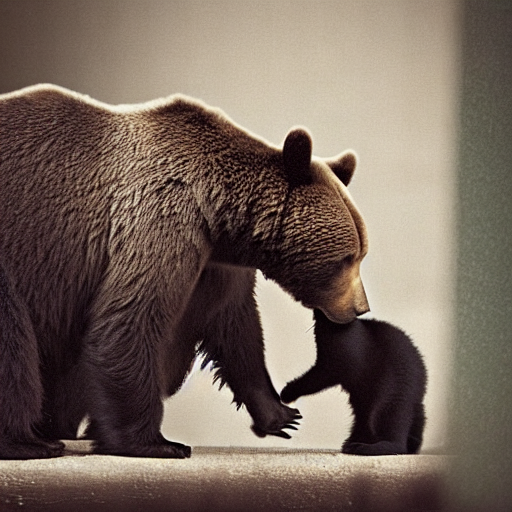

In [4]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import torch

model_path = "/home/khf/liutao/Diffusion_ReFL/checkpoint/refl"

unet = UNet2DConditionModel.from_pretrained(model_path + "/checkpoint-10/unet").to("cuda")

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

image = pipe(prompt="a bear and a cat").images[0]
display(image)

1.load BLIP model
checkpoint loaded


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


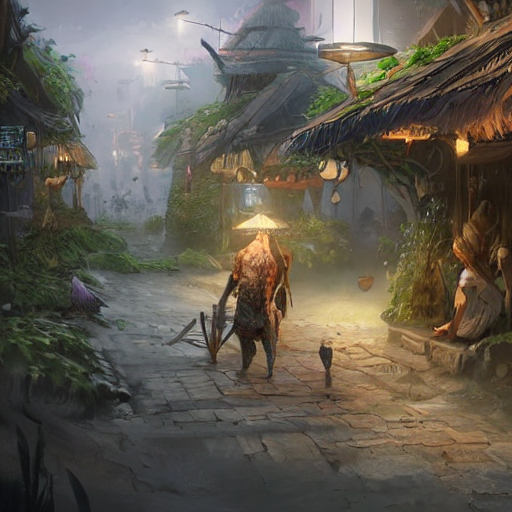

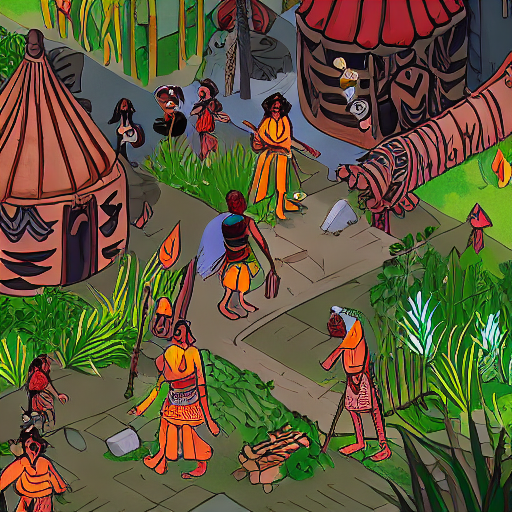

complex image shape: torch.Size([1, 3, 224, 224]), device: cuda:0
complex reward: tensor([[1.3965]], device='cuda:0') 
 simple reward: tensor([[1.4748]], device='cuda:0')


In [5]:

from  MyReward import MyReward as RM
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torch.nn.functional as F

from diffusers import StableDiffusionPipeline
from torchvision.transforms.functional import to_pil_image

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

device = "cuda:0"
med_config = "/home/khf/liutao/Diffusion_ReFL/configs/bert_config.json"

weight_path = "/home/khf/liutao/Diffusion_ReFL/models/weights/ImageReward.pt"
state_dict = torch.load(weight_path, map_location="cpu")
reward_model = RM(med_config=med_config, device = device).to(device)
msg = reward_model.load_state_dict(state_dict, strict=False)
print("checkpoint loaded")
reward_model.eval()
reward_model.requires_grad_(False)


# 生成图像

# prompts = ["snake design, fluid architecture building similar to an aerodynamic speedy car, car design, responsive parametric facade : : bird - eye view of a fluid architectural building on a lake's dam, warm colors, cold materials, zaha hadid architectural style, computational design, sustainable design, hyper realistic render", "fluid architectural building with snake design, bird-eye view on a lake's dam, warm colors, zaha hadid architectural style, computational and sustainable design, hyper realistic render"]

# prompts = ["medieval fantasy oil painting, realism, lifelike, portrait of a european dragon that is perched atop a snowy mountain peak, as a dnd characer, surrounded by brick castle fortresses, trending on artstation",
# "medieval fantasy oil painting of a lifelike european dragon perched on a snowy mountain peak, surrounded by brick castle fortresses"]

prompts = ["An concept art illustration, photorealistic tribal people working, fantasy street with huts, large insect and plant biomes, ultra realistic, style by wlop.","Tribal workers in a fantasy street with huts, surrounded by insects and plants."]

model = StableDiffusionPipeline.from_pretrained("/home/khf/liutao/sd1-4")
model.to(device)
tokenizer = model.tokenizer
text_encoder = model.text_encoder

# image = pipe(prompt).images[0]
generator = torch.Generator("cuda").manual_seed(8888)
# image = model(prompt, guidance_scale=7.5, generator=generator).images[0]

images = model(prompt=prompts, generator=generator, output_type="pt").images
display(to_pil_image(images[0]))
display(to_pil_image(images[1]))
complex_image = images[0].unsqueeze(0)
simple_image = images[1].unsqueeze(0)

complex_prompt = prompts[0]
simple_prompt = prompts[1]

# print(complex_image.shape)
# display(image)



# complex_image = model(prompt=complex_prompt, output_type="pt").images
# text_inputs = tokenizer(complex_prompt, max_length = tokenizer.model_max_length, padding="max_length", return_tensors="pt")
# print(text_inputs)

complex_text_inputs = reward_model.blip_model.tokenizer(complex_prompt, padding='max_length', truncation=True, max_length=35, return_tensors="pt")

complex_prompt_ids = complex_text_inputs.input_ids.to(device)
complex_prompt_attention_mask = complex_text_inputs.attention_mask.to(device)

simple_text_inputs = reward_model.blip_model.tokenizer(simple_prompt, padding='max_length', truncation=True, max_length=35, return_tensors="pt")

simple_prompt_ids = simple_text_inputs.input_ids.to(device)
simple_prompt_attention_mask = simple_text_inputs.attention_mask.to(device)

# print(prompt_ids)
# print(prompt_ids.shape)
# print(prompt_attention_mask)
# print(prompt_attention_mask.shape)
# # print(complex_image)

complex_image = (complex_image / 2 + 0.5).clamp(0, 1)
simple_image = (simple_image / 2 + 0.5).clamp(0, 1)
# # print(complex_image.shape)

# image encode
def _transform():
    return Compose([
        Resize(224, interpolation=BICUBIC),
        CenterCrop(224),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

rm_preprocess = _transform()
complex_image = rm_preprocess(complex_image)
simple_image = rm_preprocess(simple_image)
print(f"complex image shape: {complex_image.shape}, device: {complex_image.device}")

complex_rewards = reward_model.score_gard(complex_prompt_ids, complex_prompt_attention_mask, complex_image)
simple_rewards = reward_model.score_gard(simple_prompt_ids, simple_prompt_attention_mask, simple_image)
print(f"complex reward: {complex_rewards+2} \n simple reward: {simple_rewards+2}")


In [7]:
loss = F.relu(complex_rewards+2)
print(loss)
loss.mean()
print(loss)

tensor([[1.3965]], device='cuda:0')
tensor([[1.3965]], device='cuda:0')


In [8]:
loss = torch.tensor([[1.6061],
        [1.6972]])
print(loss)
print(loss.mean())

tensor([[1.6061],
        [1.6972]])
tensor(1.6516)


: 